# **Taxi Fare Data**

# Importing Dataset from Kaggle

In [ ]:
import kagglehub
import warnings
warnings.filterwarnings("ignore")

# Download latest version
path = kagglehub.dataset_download("hrish4/taxi-trip-fare-data-2023")

print("Path to dataset files:", path)

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 52.4M/52.4M [00:01<00:00, 52.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hrish4/taxi-trip-fare-data-2023/versions/1


In [ ]:
import os
os.listdir(path)

['Taxi_Trip_Data_preprocessed.csv']

In [ ]:
import pandas as pd
data = pd.read_csv(os.path.join(path, 'Taxi_Trip_Data_preprocessed.csv'))
data.head()

passenger_count  trip_distance payment_type  fare_amount   duration
0                1           3.70         Card         24.0  27.950000
1                1           2.77         Card         18.4  19.200000
2                1           3.30         Card         22.6  27.383333
3                1           0.30         Cash          5.1   2.550000
4                1           0.83         Card          7.2   5.250000

# Understand the data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8451090 entries, 0 to 8451089
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   passenger_count  int64  
 1   trip_distance    float64
 2   payment_type     object 
 3   fare_amount      float64
 4   duration         float64
dtypes: float64(3), int64(1), object(1)
memory usage: 322.4+ MB


In [ ]:
data.describe()

passenger_count  trip_distance   fare_amount      duration
count     8.451090e+06   8.451090e+06  8.451090e+06  8.451090e+06
mean      1.339824e+00   1.751135e+00  1.273180e+01  1.173603e+01
std       7.658024e-01   1.045488e+00  5.346809e+00  6.218064e+00
min       1.000000e+00   1.000000e-02  1.000000e-02  1.666667e-02
25%       1.000000e+00   9.700000e-01  8.600000e+00  6.900000e+00
50%       1.000000e+00   1.500000e+00  1.210000e+01  1.065000e+01
75%       1.000000e+00   2.300000e+00  1.630000e+01  1.561667e+01
max       5.000000e+00   5.230000e+00  4.080000e+01  2.995000e+01

In [ ]:
# Check for nulls
data.isnull().sum()

passenger_count    0
trip_distance      0
payment_type       0
fare_amount        0
duration           0
dtype: int64

# Handling Duplicates

In [ ]:
data.duplicated().sum()

5557871

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.shape

(2893219, 5)

# **Outliers Treatment**

In [ ]:
numerical_cols = data.select_dtypes(exclude='object').columns
numerical_cols

Index(['passenger_count', 'trip_distance', 'fare_amount', 'duration'], dtype='object')

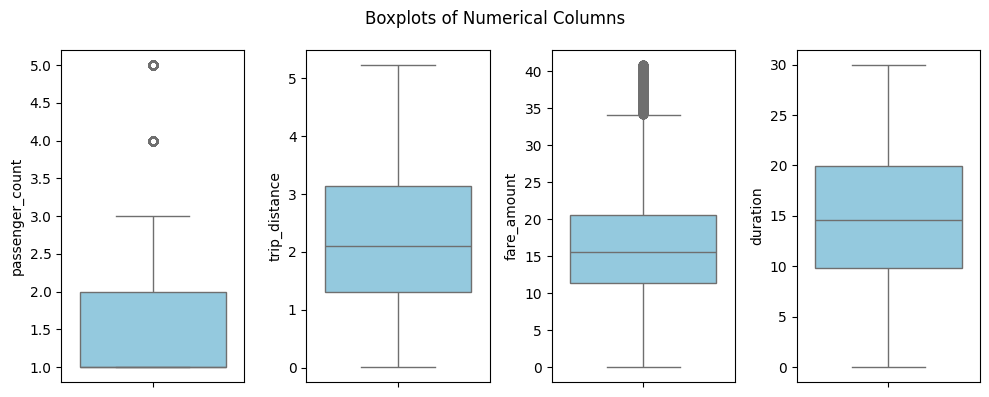

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through numerical columns and create boxplots

plt.figure(figsize=(10, 4))
plt.suptitle('Boxplots of Numerical Columns')
for i in range(0, len(numerical_cols)):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=data[numerical_cols[i]],color='skyblue',)
    plt.tight_layout()

## **Treating Outliers by calculating Z_scores**


ðŸ”¹ What is Z-Score?


> * Z-score measures how far a data point is from the mean in terms of standard deviations.

It is calculated as:

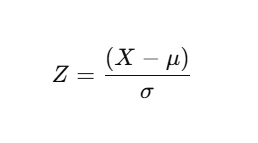


Where:

**X** = Data point

**Î¼** = Mean of the dataset

**Ïƒ** = Standard deviation


If the absolute Z-score of a data point is greater than a threshold (commonly 3), it is considered an outlier.

In [ ]:
import numpy as np
from scipy import stats

# Calculate Z-Scores
z_scores = np.abs(stats.zscore(data['fare_amount']))  # Take absolute value

# Define threshold (commonly 3)
threshold = 3

data = data[z_scores < threshold]  # selecting only the rows with Z_scores less than 3


print(data.shape)

(2891964, 5)


# Encoding

In [ ]:
encoded_df = pd.get_dummies(data['payment_type'], dtype=int)

encoded_df.columns = ['payment_type_' + col for col in encoded_df.columns]

data = pd.concat([data, encoded_df], axis=1)

data.drop('payment_type', axis=1, inplace=True)

In [ ]:
data.head()

passenger_count  trip_distance  fare_amount   duration  payment_type_Card  \
0                1           3.70         24.0  27.950000                  1   
1                1           2.77         18.4  19.200000                  1   
2                1           3.30         22.6  27.383333                  1   
3                1           0.30          5.1   2.550000                  0   
4                1           0.83          7.2   5.250000                  1   

   payment_type_Cash  
0                  0  
1                  0  
2                  0  
3                  1  
4                  0

# Skewness

In [ ]:
skewness = data.skew()
skewness

passenger_count      1.626560
trip_distance        0.461142
fare_amount          0.095767
duration             0.166679
payment_type_Card   -1.003790
payment_type_Cash    1.003790
dtype: float64

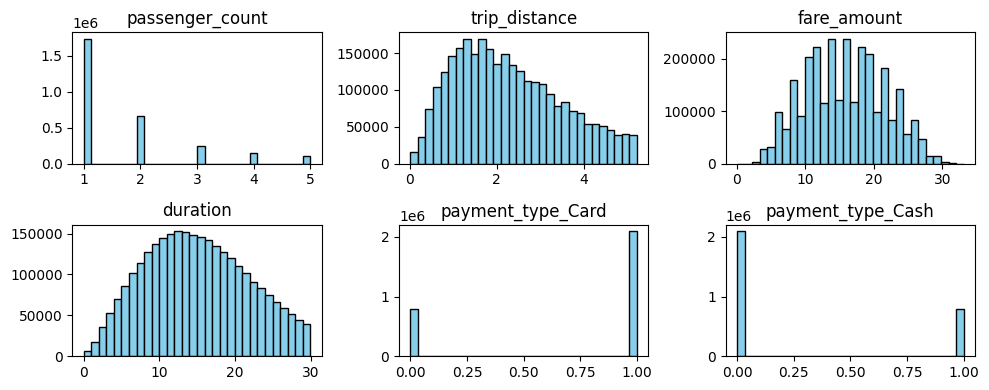

In [ ]:
# Select numerical columns with high skewness (absolute skewness > 0.5)
skewed_cols = skewness.index

# Plot histograms before transformation
plt.figure(figsize=(10,4))
for i, col in enumerate(skewed_cols, 1):
    plt.subplot(2,3,i)
    plt.hist(data[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

# Correlation

<Axes: >

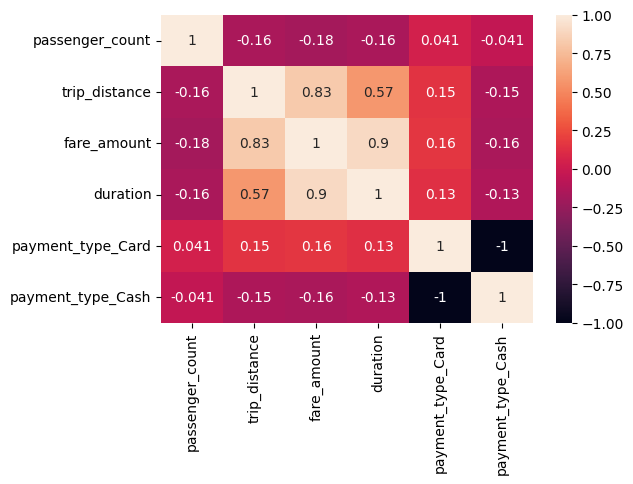

In [ ]:
corr_matrix = data.corr()
plt.subplots(figsize=(6,4))
sns.heatmap(corr_matrix,annot=True)

# Model Building

In [ ]:
data.dtypes

passenger_count        int64
trip_distance        float64
fare_amount          float64
duration             float64
payment_type_Card      int64
payment_type_Cash      int64
dtype: object

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data.to_csv("data_cleaned.csv",index=False)

In [ ]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv("data_cleaned.csv").sample(frac=0.357, random_state=42)  # sampling

In [ ]:
X = df.drop('fare_amount',axis=1)
y = df['fare_amount']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost Regressor": XGBRegressor()
}
# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on test data

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

MAE       MSE      RMSE  R2 Score
Linear Regression        0.705130  1.415296  1.189662  0.957368
Decision Tree Regressor  0.868840  2.274757  1.508230  0.931480
Random Forest Regressor  0.732615  1.491397  1.221228  0.955076
XGBoost Regressor        0.619039  1.153235  1.073888  0.965262

# Crossvalidation

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Define the model
xgb = XGBRegressor(n_estimators=100, random_state=42)

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_scores = cross_val_score(xgb, X, y, cv=kf, scoring='r2')

# Print all 5 scores
print(f"All 5-Fold Scores: {cv_scores}")
print()
# Compare Mean and Standard Deviation
print(f"Mean R2 Score: {np.mean(cv_scores):.4f}")

All 5-Fold Scores: [0.96406878 0.96670028 0.96516881 0.96521787 0.96614036]

Mean R2 Score: 0.9655


# Example code for prediction using the trained model

# Save your tuned model

In [ ]:
import pickle

with open("model.pkl",'wb') as file:
  file.dump(kf,file )

# Load your model

In [ ]:
with open("model.pkl",'r') as file:
  model = file.load(file )

# Save your preprocessors or pipeline similarly

In [ ]:
with open("preprocessor.pkl",'wb') as file:
  file.dump(preprocessor,file )

In [ ]:
with with open("pipeline.pkl",'wb') as file:
  file.dump(pipeline,file )

In [ ]:
# get the user input

my_df = {"passenger_count	": input()
        " trip_distance"	:input()
         'duration'	:input()
        'payment_type':input()}

data = pd.DataFrame(my_df)

encoded_df = pd.get_dummies(data['payment_type'], dtype=int)

encoded_df.columns = ['payment_type_' + col for col in encoded_df.columns]

data = pd.concat([data, encoded_df], axis=1)
model.predict([data])

In [ ]:
# Load the models and do the predictions on the user input

pipeline.predict(dataframe)